# Calculate non-CO2 forcing in the MPI-ESM CO2-driven runs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

In [2]:
df_myhre = pd.read_csv('../output/myhre_forcing_params.csv', index_col=0)

In [3]:
df_myhre.loc['MPI-ESM1-2-LR']

d1    7.145333
Name: MPI-ESM1-2-LR, dtype: float64

In [4]:
co2_1850=284.316999854786

def myhre(x, d):
    return d * np.log(x/co2_1850)

In [5]:
df_co2_conc_ssp = pd.read_csv('../data/ssp_co2_concentration.csv', index_col=0)

In [6]:
colors = {
    'esm-hist': '#000000',
    'esm-ssp119': '#00a9cf',
    'esm-ssp126': '#003466',
    'esm-ssp245': '#f69320',
    'esm-ssp370': '#df0000',
    'esm-ssp534-over': '#92397a',
    'esm-ssp585': '#980002'
}

Text(0, 0.5, 'W/m2')

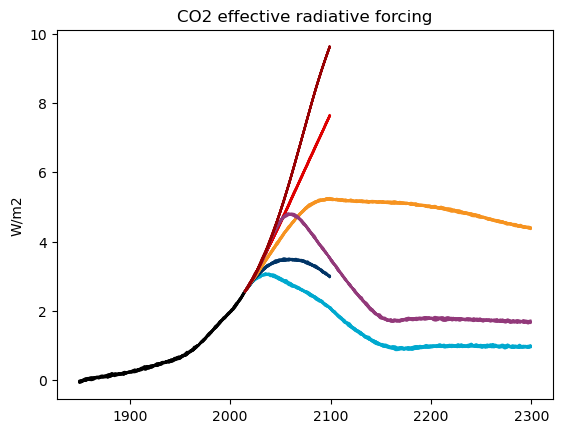

In [7]:
for scenario in ['esm-hist', 'esm-ssp119', 'esm-ssp126', 'esm-ssp245', 'esm-ssp370', 'esm-ssp534-over', 'esm-ssp585']:
# for scenario in ['esm-hist', 'esm-ssp119', 'esm-ssp126', 'esm-ssp245', 'esm-ssp370', 'esm-ssp534-over', 'esm-ssp585']:
    # anomalies only processed for 10 runs
    for run in range(1, 11):
        df_co2 = pd.read_csv(f'../output/processed/MPI-ESM1-2-LR//{scenario}/co2_vmr/r{run}i1p1f1.csv', index_col=0)
        f_co2 = myhre(df_co2, *df_myhre.loc['MPI-ESM1-2-LR'].values)
        pl.plot(f_co2, color=colors[scenario])
pl.title('CO2 effective radiative forcing')
pl.ylabel('W/m2')

### Then, use Hege's method to make the forcing estimate

In [8]:
def load_anom(model, exp, member, length_restriction = None, path='../data/processed_data', my_ssp=False):
    if my_ssp:
        filename = f'{member}.csv'
    else:
        filename = model + '_' + exp + '_' + member + '_anomalies.csv'
    file = f'{path}/{model}/{exp}/anomalies/{filename}'
    data = pd.read_csv(file, index_col=0)
    if length_restriction != None:
        data = data[:length_restriction]
    return data

In [9]:
def forcing_F13(tasdata, Ndata, model, years = None):
    parameter_table = pd.read_csv('../data/best_estimated_parameters_allmembers4xCO2.csv', index_col=0)
    if years == None:
        GregoryT2x = parameter_table.loc[model,'GregoryT2x']
        GregoryF2x = parameter_table.loc[model,'GregoryF2x']
    if years == '1-20':
        GregoryT2x = parameter_table.loc[model,'GregoryT2x_1-20']
        GregoryF2x = parameter_table.loc[model,'GregoryF2x_1-20']
    fbpar = GregoryF2x/GregoryT2x
    F = Ndata + fbpar*tasdata
    return F

In [10]:
def tas_predictors(t, fixed_par, exptype = 'stepforcing', timevaryingforcing = []):
    # compute components/predictors for T_n(t) = exp(-t/tau_n)*F(t) (* is a convolution)
    # input for stepforcing: years, fixed parameters (timescales for stepforcing)
    # stepforcing_ computes response to unit forcing,
    # to be multiplied by the actual forcing afterwards
    
    # timevaryingforcing: need a forcing time series input
    if exptype == 'stepforcing':
        timescales = fixed_par; dim = len(timescales)
        predictors = np.zeros((len(t),dim))
        for i in range(0,dim): 
            predictors[:,i] = (1 - np.exp((-t)/timescales[i]))
    elif exptype == 'timevaryingforcing': # need forcing input
        # compute components T_n(t) = exp(-t/tau_n)*F(t) (Here * is a convolution)
        timescales = fixed_par
        lf = len(timevaryingforcing); dim = len(timescales)
        predictors = np.full((lf,dim),np.nan)   

        # compute exact predictors by integrating greens function
        for k in range(0,dim):
            # dot after 0 to create floating point numbers:
            intgreensti = np.full((lf,lf),0.)   
            for t in range(0,lf):
                # compute one new contribution to the matrix:
                intgreensti[t,0] = timescales[k]*(np.exp(-t/timescales[k]) - np.exp(-(t+1)/timescales[k]))
                # take the rest from row above:
                if t > 0:
                    intgreensti[t,1:(t+1)] = intgreensti[t-1,0:t]
            # compute discretized convolution integral by this matrix product:
            predictors[:,k] = intgreensti@np.array(timevaryingforcing)
    else:
        print('unknown exptype')
    return predictors

In [11]:
model_names = ['MPI-ESM1-2-LR']

In [12]:
ensemble_members = {
    'esm-hist': 10,
    'esm-ssp119': 10,
    'esm-ssp126': 10,
    'esm-ssp245': 10,
    'esm-ssp370': 10,
    'esm-ssp534-over': 10,
    'esm-ssp585': 10,
}

In [13]:
exp = 'esm-hist'

In [14]:
it = 20  # number of iterations

for model in model_names:
    members = [f'r{run}i1p1f1' for run in range(1, ensemble_members[exp]+1)]
    branch_time_file = f'../data/branch_times/{model}_branch_times.csv'
    table = pd.read_table(branch_time_file,index_col=0, sep = ',')
    exptable = table.loc[table['exp'] == exp]
    
    # load parameters needed to make new forcing estimate:
    filename = '../data/best_estimated_parameters_allmembers4xCO2.csv'
    parameter_table = pd.read_csv(filename, index_col=0)
    taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
    a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
    b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
    F2x = parameter_table.loc[model,'F2x']
    T2x = parameter_table.loc[model,'T2x']
    dim = len(taulist)
    if any(a_n == 0):
        dim = np.count_nonzero(a_n[:dim])
        zeroindex = np.where(a_n == 0)[0]
        a_n = np.delete(a_n,zeroindex)
        b_n = np.delete(b_n,zeroindex)
        taulist = np.delete(taulist,zeroindex)
    fbparlist = (b_n/a_n)[:dim]
    amplitudes = a_n[:dim]/(2*F2x*taulist)
    
    for member in members:
        member_df = exptable.loc[exptable['member'] == member]
        data = load_anom(model, exp, member)
        if data.empty:
            print('Empty dataframe for', model, exp, member)
            continue
        years = data.index
        N = data['rsdt'] - data['rsut'] - data['rlut']
        F = forcing_F13(data['tas'], N, model)
        t = np.arange(0,len(F))
        
        # Compute new estimate of forcing
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)
            
        index = pd.Index(years, name='Year')
        df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
        
        os.makedirs(f'../output/processed/{model}/{exp}/erf/', exist_ok=True)
        df_F.to_csv(f'../output/processed/{model}/{exp}/erf/{member}.csv')

In [15]:
for model in model_names:
    for exp in ['esm-ssp119', 'esm-ssp126', 'esm-ssp245', 'esm-ssp370', 'esm-ssp534-over', 'esm-ssp585']:
        members = [f'r{run}i1p1f1' for run in range(1, ensemble_members[exp]+1)]
        branch_time_file = f'../data/branch_times/{model}_branch_times.csv'
        table = pd.read_table(branch_time_file,index_col=0, sep = ',')
        exptable = table.loc[table['exp'] == exp]

        # load parameters needed to make new forcing estimate:
        filename = '../data/best_estimated_parameters_allmembers4xCO2.csv'
        parameter_table = pd.read_csv(filename, index_col=0)
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']
        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        for member in members:
            member_df = exptable.loc[exptable['member'] == member]
            if exp=='esm-ssp585':
                data = load_anom(model, exp, member, my_ssp=False)
            else:
                data = load_anom(model, exp, member, path=f'../output/processed/', my_ssp=True)
            if data.empty:
                print('Empty dataframe for', model, exp, member)
                continue
            # load historical data also and concatenate
            parent_member = member_df['parent_variant_id'].values[0]
            historical_data = load_anom(model, 'esm-hist', parent_member)
            data = pd.concat([historical_data, data])
            years = data.index
            N = data['rsdt'] - data['rsut'] - data['rlut']
            F = forcing_F13(data['tas'], N, model)
            t = np.arange(0,len(F))

            # Compute new estimate of forcing
            Fiarray = np.full((len(F),it),np.nan)
            Tiarray = np.full((len(F),it),np.nan)

            Fi = F
            for i in range(0,it):
                tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = Fi)
                Tni = amplitudes*tas_pred
                Fi = N + Tni@fbparlist
                Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

            index = pd.Index(years, name='Year')
            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])

            os.makedirs(f'../output/processed/{model}/{exp}/erf/', exist_ok=True)
            df_F.to_csv(f'../output/processed/{model}/{exp}/erf/{member}.csv')

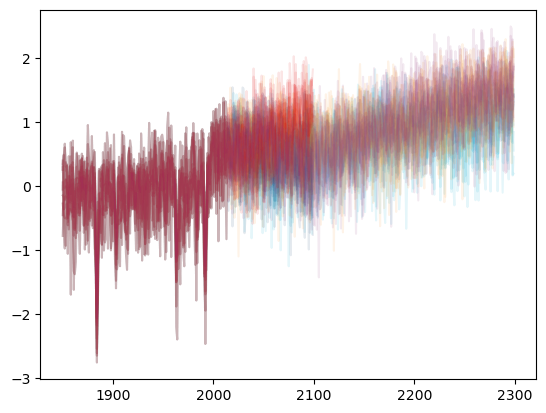

In [16]:
for model in model_names:
    for exp in ['esm-ssp119', 'esm-ssp126', 'esm-ssp245', 'esm-ssp370', 'esm-ssp534-over']:
        members = [f'r{run}i1p1f1' for run in range(1, ensemble_members[exp]+1)]
        for member in members:
            df_F_hist = pd.read_csv(f'../output/processed/{model}/esm-hist/erf/{member}.csv', index_col=0)
            df_co2_hist = pd.read_csv(f'../output/processed/{model}/esm-hist/co2_vmr/{member}.csv', index_col=0)
            f_co2_hist = myhre(df_co2_hist, *df_myhre.loc['MPI-ESM1-2-LR'].values)
            f_non_co2_hist = df_F_hist.values - f_co2_hist.values
            df_F = pd.read_csv(f'../output/processed/{model}/{exp}/erf/{member}.csv', index_col=0)
            df_co2 = pd.read_csv(f'../output/processed/{model}/{exp}/co2_vmr/{member}.csv', index_col=0)
            f_co2 = myhre(df_co2, *df_myhre.loc['MPI-ESM1-2-LR'].values)
            f_non_co2 = df_F.loc[2015:].values - f_co2.values
            os.makedirs(f'../output/processed/{model}/{exp}/non-co2_erf/', exist_ok=True)
            df_nonco2 = pd.DataFrame(np.concatenate((f_non_co2_hist, f_non_co2)), index=np.concatenate((df_F_hist.index, df_F.loc[2015:].index)), columns=['nonCO2_erf'])
            df_nonco2.to_csv(f'../output/processed/{model}/{exp}/non-co2_erf/{member}.csv')
            pl.plot(df_nonco2, color=colors[exp], alpha=0.1)

In [17]:
avg119 = np.zeros((450, 10))
avg245 = np.zeros((450, 10))
avg534 = np.zeros((450, 10))
for im, member in enumerate(members):
    df_nonco2 = pd.read_csv(f'../output/processed/{model}/esm-ssp119/non-co2_erf/{member}.csv')
    avg119[:, im] = df_nonco2['nonCO2_erf'].values
    df_nonco2 = pd.read_csv(f'../output/processed/{model}/esm-ssp245/non-co2_erf/{member}.csv')
    avg245[:, im] = df_nonco2['nonCO2_erf'].values
    df_nonco2 = pd.read_csv(f'../output/processed/{model}/esm-ssp534-over/non-co2_erf/{member}.csv')
    avg534[:, im] = df_nonco2['nonCO2_erf'].values
avg119 = np.mean(avg119, axis=1)
avg245 = np.mean(avg245, axis=1)
avg534 = np.mean(avg534, axis=1)

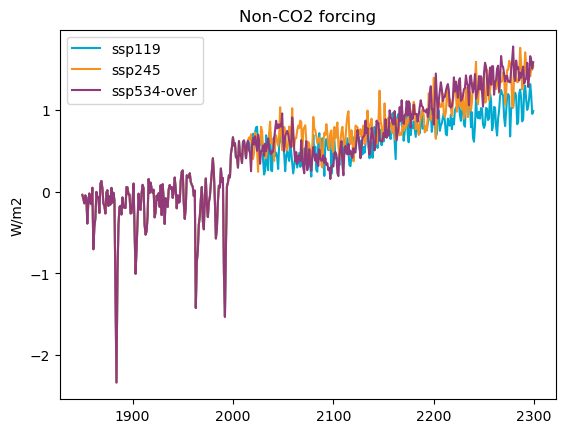

In [18]:
pl.plot(np.arange(1850, 2300), avg119, label='ssp119', color=colors['esm-ssp119'])
pl.plot(np.arange(1850, 2300), avg245, label='ssp245', color=colors['esm-ssp245'])
pl.plot(np.arange(1850, 2300), avg534, label='ssp534-over', color=colors['esm-ssp534-over'])
pl.title('Non-CO2 forcing')
pl.ylabel('W/m2')
pl.legend()

In [20]:
avg119 = np.zeros((450, 10))
avg245 = np.zeros((450, 10))
avg534 = np.zeros((450, 10))
for im, member in enumerate(members):
    df_erf = pd.read_csv(f'../output/processed/{model}/esm-ssp119/erf/{member}.csv')
    avg119[:, im] = df_erf['ERF'].values
    df_erf = pd.read_csv(f'../output/processed/{model}/esm-ssp245/erf/{member}.csv')
    avg245[:, im] = df_erf['ERF'].values
    df_erf = pd.read_csv(f'../output/processed/{model}/esm-ssp534-over/erf/{member}.csv')
    avg534[:, im] = df_erf['ERF'].values
avg119 = np.mean(avg119, axis=1)
avg245 = np.mean(avg245, axis=1)
avg534 = np.mean(avg534, axis=1)

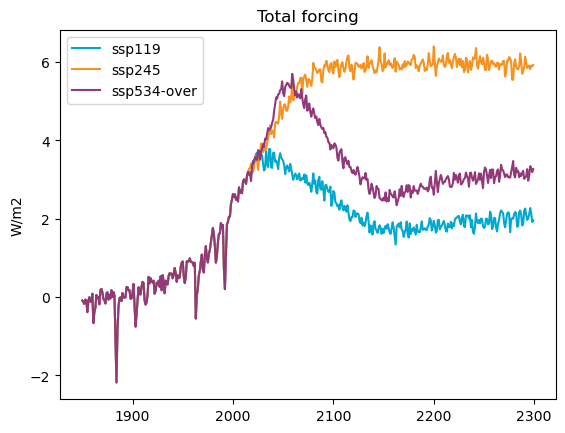

In [21]:
pl.plot(np.arange(1850, 2300), avg119, label='ssp119', color=colors['esm-ssp119'])
pl.plot(np.arange(1850, 2300), avg245, label='ssp245', color=colors['esm-ssp245'])
pl.plot(np.arange(1850, 2300), avg534, label='ssp534-over', color=colors['esm-ssp534-over'])
pl.title('Total forcing')
pl.ylabel('W/m2')
pl.legend()